# Project on recommander systems : Third Environmement

#### Author : Raymond KUOCH and Alexandre MAXINSANG

In [150]:
import requests
import time
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dropout, Dense
from keras.models import Model
from keras.utils import plot_model

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from IPython.display import Image

## Get The Data

In [70]:
#attributes 
USER_ID = 'IAHIZPIW80WPGDW7P7JE'
BASE_URL = "http://35.180.178.243"
url_reset = BASE_URL + "/reset"
url_predict = BASE_URL + "/predict"
params = {"user_id" : USER_ID}

def load_data(url_reset,params) :
    r = requests.get(url=url_reset, params=params)
    data = r.json()
    return data

data = load_data(url_reset,params)
nb_users = data["nb_users"]
nb_items = data["nb_items"]
next_state = data["next_state"]

data.keys()

dict_keys(['action_history', 'nb_items', 'nb_users', 'next_state', 'rewards_history', 'state_history'])

In [71]:
blacklisted_set = set(("next_state","nb_items","nb_users"))
new_dict = {key : value for key, value in data.items() if key not in blacklisted_set}

df = pd.DataFrame(new_dict)
df.head()

,action_history,rewards_history,state_history
0,20,0.000000,"[[8, 0, 45.63728801221079, 2.6725193925993143,..."
1,2,0.000000,"[[29, 0, 45.63728801221079, 0.1561980677443061..."
2,26,0.000000,"[[23, 0, 45.63728801221079, 3.5799797302261704..."
3,7,468.002443,"[[49, 0, 45.63728801221079, 0.1356474524899955..."
4,24,0.000000,"[[50, 0, 45.63728801221079, -0.515370624544243..."


In [72]:
df.describe()

,action_history,rewards_history
count,200.000000,200.000000
mean,14.450000,192.972800
std,8.204515,311.817769
min,0.000000,0.000000
25%,8.000000,0.000000
50%,14.000000,0.000000
75%,21.250000,468.002443
max,29.000000,990.309864


In [73]:
df[df['rewards_history']==0].count()

action_history     132
rewards_history    132
state_history      132
dtype: int64

In [74]:
users_items_df = []
for i in range(df.shape[0]):
    users_items_df += df['state_history'][i] 
    
users_items_df = pd.DataFrame(users_items_df,columns = ['user_id','item_id',
                                                        'price','v1','v2','v3','v4','v5'])
users_items_df

,user_id,item_id,price,v1,v2,v3,v4,v5
0,8,0,45.637288,2.672519,2.710697,1.997002,1.358978,1.121579
1,8,1,36.177025,2.672519,2.710697,0.664057,0.911352,1.483312
2,8,2,976.646282,2.672519,2.710697,0.337752,2.157311,-0.763668
3,8,3,777.420662,2.672519,2.710697,0.649728,1.766307,0.530752
4,8,4,887.343487,2.672519,2.710697,1.030800,1.038443,-0.860784
5,8,5,557.167740,2.672519,2.710697,0.104437,0.745774,1.454469
6,8,6,887.150616,2.672519,2.710697,-0.857658,0.691669,-0.258284
7,8,7,468.002443,2.672519,2.710697,0.197570,0.650010,0.906133
8,8,8,372.511602,2.672519,2.710697,-0.657884,0.058255,1.814888
9,8,9,616.191471,2.672519,2.710697,0.675207,-0.216844,0.345592


In [75]:
# Eliminate the 'v5'
new_users_items_df = users_items_df.drop(columns='v5').drop_duplicates() 

In [76]:
# We can see that the first two covariates variables are features about users 
# and the forth and fifth variable are features about items
# The variable 5 depends on .....

user_v1 = users_items_df['v1'].unique()
user_v2 = users_items_df['v2'].unique()
users_ids = users_items_df['user_id'].unique()
users_content= pd.DataFrame({'user_id' : users_ids,'v1':user_v1,'v2':user_v2 })

item_v3 = users_items_df['v3'].unique()
item_v4 = users_items_df['v4'].unique()
item_id = users_items_df['item_id'].unique()
items_content= pd.DataFrame({'item_id' : item_id,'v3':item_v3,'v4':item_v4 })

In [77]:
users_content

,user_id,v1,v2
0,8,2.672519,2.710697
1,29,0.156198,1.211929
2,23,3.579980,-0.429931
3,49,0.135647,3.574934
4,50,-0.515371,0.407560
5,61,2.040257,-0.485274
6,21,0.230367,1.841019
7,35,3.205260,-0.386073
8,93,1.900613,0.735791
9,83,0.137273,1.274005


In [78]:
# We don't have all the metadata from all the users
users_content['user_id'].unique().shape

(91,)

## Data Preprocessing

In [79]:
pos_df = df[df["rewards_history"] > 0].reset_index(drop=True)
neg_df = df[df["rewards_history"] == 0].reset_index(drop=True)

In [80]:
pos_df["user_id"] = [pos_df["state_history"][i][0][0] for i in range(pos_df.shape[0])]
pos_df["item_id_action"] = [pos_df["state_history"][i][pos_df["action_history"][i]][1] for i in range(pos_df.shape[0])]
pos_df.head()## There are some users that have more than one positive item

,action_history,rewards_history,state_history,user_id,item_id_action
0,7,468.002443,"[[49, 0, 45.63728801221079, 0.1356474524899955...",49,7
1,2,976.646282,"[[21, 0, 45.63728801221079, 0.2303667552366982...",21,2
2,25,154.396372,"[[35, 0, 45.63728801221079, 3.2052596765490757...",35,25
3,13,990.309864,"[[5, 0, 45.63728801221079, -0.0093813677387590...",5,13
4,15,662.539654,"[[49, 0, 45.63728801221079, 0.1356474524899955...",49,16


In [81]:
neg_df["user_id"] = [neg_df["state_history"][i][0][0] for i in range(neg_df.shape[0])]
neg_df["item_id_action"] = [neg_df["state_history"][i][neg_df["action_history"][i]][1] for i in range(neg_df.shape[0])]
neg_df.head()

,action_history,rewards_history,state_history,user_id,item_id_action
0,20,0.0,"[[8, 0, 45.63728801221079, 2.6725193925993143,...",8,20
1,2,0.0,"[[29, 0, 45.63728801221079, 0.1561980677443061...",29,2
2,26,0.0,"[[23, 0, 45.63728801221079, 3.5799797302261704...",23,26
3,24,0.0,"[[50, 0, 45.63728801221079, -0.515370624544243...",50,24
4,16,0.0,"[[61, 0, 45.63728801221079, 2.040256686435062,...",61,16


# Models

In [82]:
import tensorflow as tf

def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred + 0 * y_true)


def margin_comparator_loss(inputs, margin=1.):
    """Comparator loss for a pair of precomputed similarities
    
    If the inputs are cosine similarities, they each have range in
    (-1, 1), therefore their difference have range in (-2, 2). Using
    a margin of 1. can therefore make sense.

    If the input similarities are not normalized, it can be beneficial
    to use larger values for the margin of the comparator loss.
    """
    positive_pair_sim, negative_pair_sim = inputs
    return tf.maximum(negative_pair_sim - positive_pair_sim + margin, 0)

## Naive Model : Recommand the most expensive item

In [83]:
def naive_model_expensive(state):
    greater_index = 0
    greater_value = 0
    
    for i in range(len(state)):
        if(state[i][2] > greater_value):
            greater_value = state[i][2]
            greater_index = i
    return greater_index  

In [84]:
USER_ID = 'Y6EKWA0GK1D0VCTN0RT7'
BASE_URL = "http://35.180.178.243"
url_reset = BASE_URL + "/reset"
url_predict = BASE_URL + "/predict"
params = {"user_id" : USER_ID}

def load_data(url_reset,params) :
    r = requests.get(url=url_reset, params=params)
    data = r.json()
    return data

def build_dataframe(data) : 
    df = pd.DataFrame({"action":data["action_history"], "reward":data["rewards_history"], "item":data["state_history"]})
    return df

def prepare_data(df) : 
    x, y = [], []
    for action, reward, item in zip(df["action"], df["reward"], df["item"]) : 
        x.append(item[action][2:]) # We do not take care of the item_id and user_id
        y.append(reward > 0) # True if reward > 0 else False
    return x, y

In [100]:
number_run = 3
generations = 1000
mean = 0

for k in range(1, number_run+1):

    # Load the data
    params = {"user_id" : USER_ID}
    data = load_data(url_reset, params)
    # Build the dataframe and prepare the data
    df = build_dataframe(data)
    x, y = prepare_data(df)
    next_state = data["next_state"]

    total_reward = 0
    purchase = 0
    
    for i in range(generations):

        predicted_item = naive_model_expensive(next_state)

        params['recommended_item'] = predicted_item

        r = requests.get(url = url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward
        next_state = r['state']
        
        if reward > 0 :
            purchase += 1

    mean += total_reward

    print("Total reward at run %d : %d with conversion rate %.3f" % (k, total_reward, purchase/generations))
print("Mean of total reward over 3 independant runs : %d" % (mean/3))

Total reward at run 1 : 221586 with conversion rate 0.235
Total reward at run 2 : 213815 with conversion rate 0.242
Total reward at run 3 : 210671 with conversion rate 0.232
Mean of total reward over 3 independant runs : 215357


## Naive Model : Recommand The cheapest item

In [34]:
def naive_model_cheapest(state):
    cheapest_index = 0
    cheapest_value =  state[0][2]
    
    for i in range(len(state)):
        if(state[i][2] < cheapest_value):
            cheapest_value = state[i][2]
            cheapest_index = i
            
    return cheapest_index  

In [86]:
number_run = 3
generations = 1000
mean = 0

for k in range(1, number_run+1):

    # Load the data
    params = {"user_id" : USER_ID}
    data = load_data(url_reset, params)
    # Build the dataframe and prepare the data
    df = build_dataframe(data)
    x, y = prepare_data(df)
    next_state = data["next_state"]

    total_reward = 0
    purchase = 0

    for i in range(generations):

        predicted_item = naive_model_cheapest(next_state)

        params['recommended_item'] = predicted_item

        r = requests.get(url = url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward
        next_state = r['state']
        
        if reward > 0 : 
            purchase += 1

    mean += total_reward

    print("Total reward at run %d : %d with conversion rate %.3f" % (k, total_reward, purchase/generations))
print("Mean of total reward over 3 independant runs : %d" % (mean/3))

Total reward at run 1 : 10406 with conversion rate 0.299
Total reward at run 2 : 32463 with conversion rate 0.262
Total reward at run 3 : 14882 with conversion rate 0.226
Mean of total reward over 3 independant runs : 19250


> <font color='blue'>
    As naive models, the strategy of always recommending the most expensive item (in order to get the biggest reward) always works best. Indeed, the conversion rate is about the same for these two strategies but "Most Expensive Model" bring more rewards. We will now try the deep models seen in class.
    </font>

## Model 1 (without covariates)

In [88]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense
from keras.layers import Lambda, Dot
from keras.regularizers import l2
from keras.layers.merge import dot, concatenate


def build_models(n_users, n_items, latent_dim=64, l2_reg=0):
    """Build a triplet model and its companion similarity model
    
    The triplet model is used to train the weights of the companion
    similarity model. The triplet model takes 1 user, 1 positive item
    (relative to the selected user) and one negative item and is
    trained with comparator loss.
    
    The similarity model takes one user and one item as input and return
    compatibility score (aka the match score).
    """
    # Common architectural components for the two models:
    # - symbolic input placeholders
    user_input = Input((1,), name='user_input')
    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')

    # - embeddings
    l2_reg = None if l2_reg == 0 else l2(l2_reg)
    user_layer = Embedding(input_dim=n_users + 1, output_dim=latent_dim, input_length=1,
                           name='user_embedding', embeddings_regularizer=l2_reg)
    
    # The following embedding parameters will be shared to encode both
    # the positive and negative items.
    item_layer = Embedding(input_dim=n_items + 1, output_dim=latent_dim, input_length=1,
                           name="item_embedding", embeddings_regularizer=l2_reg)

    user_embedding = Flatten()(user_layer(user_input))
    positive_item_embedding = Flatten()(item_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_layer(negative_item_input))

    # - similarity computation between embeddings
    positive_similarity = Dot(name="positive_similarity",
                              axes=1, normalize=True)(
        [user_embedding, positive_item_embedding])
    negative_similarity = Dot(name="negative_similarity",
                              axes=1, normalize=True)(
        [user_embedding, negative_item_embedding])

    # The triplet network model, only used for training
    triplet_loss = Lambda(margin_comparator_loss,
                          name='comparator_loss',
                          output_shape=(1,))([positive_similarity, negative_similarity])

    triplet_model = Model(inputs=[user_input,
                                  positive_item_input,
                                  negative_item_input],
                          outputs=triplet_loss)
    
    # The match-score model, only use at inference to rank items for a given
    # model: the model weights are shared with the triplet_model therefore
    # we do not need to train it and therefore we do not need to plug a loss
    # and an optimizer.
    match_model = Model(inputs=[user_input, positive_item_input],
                        outputs=positive_similarity)
    
    return triplet_model, match_model


In [89]:
def sample_triplets(pos_df,max_items):
    """
    Sample negatives at random
    
    """
    range_itens = np.arange(max_items)
    user_ids = pos_df['user_id'].values
    pos_item_ids = pos_df['item_id_action'].values
    
    
    user_pos_items = pos_df.groupby('user_id')['item_id_action'].apply(list)
    neg_item_ids = np.array([])
    for i in user_ids:
        if i in set(user_pos_items.index):
            number = np.random.choice([item for item in range_itens 
                                       if not item in user_pos_items[user_pos_items.index == i]])
        else:
            number = np.random.choice(range_itens,1)
        neg_item_ids = np.append(neg_item_ids,number)
    
  
    return [user_ids, pos_item_ids, neg_item_ids]

In [90]:
number_run = 3
n_epochs = 1
total_reward = 0
generations = 1000
max_items = 30
mean = 0

for k in range(number_run):
    
    # Load the data
    params = {"user_id" : USER_ID}
    data = load_data(url_reset, params)
    # Build the dataframe and prepare the data
    
    pos_df = df[df["reward"] > 0].reset_index(drop=True)
    pos_df["user_id"] = [pos_df["item"][i][0][0] for i in range(pos_df.shape[0])]
    pos_df["item_id_action"] = [pos_df["item"][i][pos_df["action"][i]][1] for i in range(pos_df.shape[0])]

    total_reward = 0
    purchase = 0
    
    triplet_model, match_model = build_models(nb_users, nb_items, latent_dim=16, l2_reg=1e-6)
    # we plug the identity loss and the a fake target variable ignored by
    # the model to be able to use the Keras API to train the triplet model
    triplet_model.compile(loss=identity_loss, optimizer="adam")
    fake_y = np.ones_like(pos_df['user_id'])
    params = {'user_id': USER_ID}
    
    positive_data = pos_df.copy()
    
    for i in range(n_epochs):
        # Sample new negatives to build different triplets at each epoch
        triplet_inputs = sample_triplets(positive_data, max_items=nb_items)

        # Fit the model incrementally by doing a single pass over the
        # sampled triplets.
        triplet_model.fit(triplet_inputs, fake_y, shuffle=True, epochs=1)

    for j in range(generations):


        # The user that we need to recommend a product
        new_user_id = next_state[0][0]
        # Take all the items in the new state
        items_ids = np.array([next_state[i][1]
                              for i in range(len(next_state))])

        # Create an array of the same size of 'items_ids' of all values equal to 'new_user_id'
        repeated_user_id = np.empty_like(items_ids)
        repeated_user_id.fill(new_user_id)

        # predict the product using our model
        predicted = match_model.predict([repeated_user_id, items_ids])
        predicted_item = np.argmax(predicted)
        params['recommended_item'] = predicted_item

        # take the reward from the API
        r = requests.get(url=url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward

        # (Online learning)Check if the reward is greater than 0 , if yes train again 
        # the model the sample point
        if(reward > 0):
            purchase += 1
            range_itens = np.arange(max_items)
            user_pos_items = pos_df.groupby('user_id')['item_id_action'].apply(list)
            if new_user_id in set(user_pos_items.index):
                neg_item_id = np.random.choice([item for item in range_itens 
                                           if not item in user_pos_items[user_pos_items.index == new_user_id]])
            else:
                neg_item_id = np.random.choice(range_itens,1)
            
           
            
            triplet_inputs = [[new_user_id], [predicted_item], [neg_item_id]]
    
            fake_y = np.ones_like([1])
            triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                               batch_size=64, epochs=1)
    
            
        # Take the nexr_state
        next_state = r['state']
    
    mean += total_reward
        
    print("Total reward at run %d : %d with conversion rate %.3f" % (k, total_reward, purchase/generations))
print("Mean of total reward over 3 independant runs : %d" % (mean/3))

Epoch 1/1
63/63 [==============================] - 1s 9ms/step - loss: 1.1009
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2157
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.2438
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.2358
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.4087
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.4495
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.8381
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.6618
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.6220
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9928
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.5312
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.1299
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 1/1


Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.6341e-06
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.2506
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.2525
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4108
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.5459
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.4955
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9359
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7288
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.3282
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0863
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.5111
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7999
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.9424
Epoch 1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8280
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.1621
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.7431
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.8452
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.9991
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.3979
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8714
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0482
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.6948
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2415
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5524
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5533
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.8538
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.0701
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.2258
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6329
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5869
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3405
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.7392
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3407
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4447
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.7976
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3825
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.2382
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.3595
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3385
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.1990
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.3913
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.4386
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.8805
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.3134
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.4522
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.6075
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.7638
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4217
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0144
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.3518
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6190
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.9640
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.2532
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.8428
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.4934
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0674
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7948
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.7608
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.6420
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.5305
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.4392
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3878
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8989
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.0338
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9958
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.4735
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.9329
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.5057
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.2095
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.4683
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.6232
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.4767
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6205
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0676
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.3801
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.6225
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.0392
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5675
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2840
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9533
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8377
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.9013
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 2.2000
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.5810
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6593
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.1109
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9199
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.1951
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.4273
Epoch 1/1
1/

The results for this model are :
- Total reward at run 0 : 118653 with conversion rate 0.254
- Total reward at run 1 : 128638 with conversion rate 0.272
- Total reward at run 2 : 111897 with conversion rate 0.242
- Mean of total reward over 3 independant runs : 119729

> <font color='blue'>
    The conversion rate is almost the same with the Dot Model (25% in average of conversion rate). But the most important thing is that The cumulative reward is much lower than with the naive model (Mean of total reward for the most expensive model : 215357). This may be due to the small amount of database in the learning data. Let's try a deeper model and see the results.

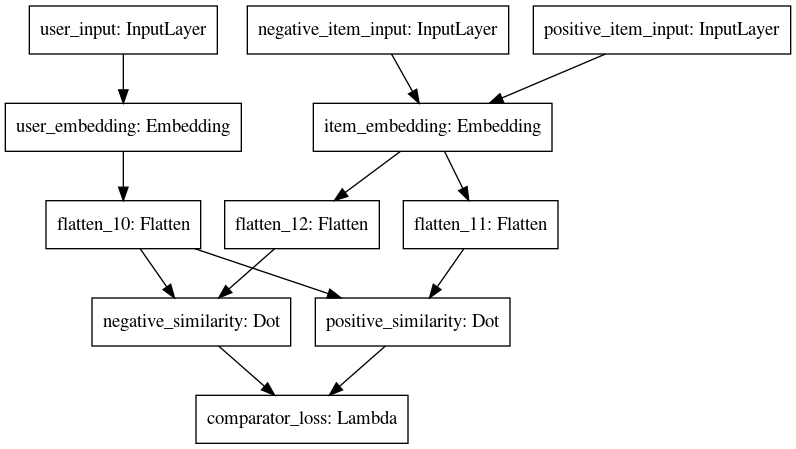

In [46]:
plot_model(triplet_model, to_file='triplet_model.png')
Image(filename='triplet_model.png') 

## Model 2(with deep learning and covariates)

In [91]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dense, Dropout
from keras.layers import Concatenate, Lambda
from keras.regularizers import l2


def make_interaction_mlp(input_dim, n_hidden=1, hidden_size=64,
                         dropout=0, l2_reg=None):
    """
    Build the shared multi layer perceptron

    """
    mlp = Sequential()
    if n_hidden == 0:
        # Plug the output unit directly: this is a simple
        # linear regression model. Not dropout required.
        mlp.add(Dense(1, input_dim=input_dim,
                      activation='relu', kernel_regularizer=l2_reg))
    else:
        mlp.add(Dense(hidden_size, input_dim=input_dim,
                      activation='relu', kernel_regularizer=l2_reg))
        mlp.add(Dropout(dropout))
        for i in range(n_hidden - 1):
            mlp.add(Dense(hidden_size, activation='relu',
                          kernel_regularizer=l2_reg))
            mlp.add(Dropout(dropout))
        mlp.add(Dense(1, activation='relu', kernel_regularizer=l2_reg))
    return mlp


def build_models(n_users, n_items, user_dim=32, item_dim=64,
                 n_hidden=1, hidden_size=64, dropout=0, l2_reg=0):
    """
    Build models to train a deep triplet network

    """
    user_input = Input((1,), name='user_input')
    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')
    positive_meta_input = Input((2,), name='positive_meta_input')
    negative_meta_input = Input((2,), name='negative_meta_input')

    l2_reg = None if l2_reg == 0 else l2(l2_reg)
    user_layer = Embedding(n_users + 1, user_dim, input_length=1,
                           name='user_embedding', embeddings_regularizer=l2_reg)

    # The following embedding parameters will be shared to encode both
    # the positive and negative items.
    item_layer = Embedding(n_items + 1, item_dim, input_length=1,
                           name="item_embedding", embeddings_regularizer=l2_reg)

    user_embedding = Flatten()(user_layer(user_input))
    positive_item_embedding = Flatten()(item_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_layer(negative_item_input))

    # Similarity computation between embeddings using a MLP similarity
    positive_embeddings_pair = Concatenate(name="positive_embeddings_pair")(
        [user_embedding, positive_item_embedding, positive_meta_input])
    positive_embeddings_pair = Dropout(dropout)(positive_embeddings_pair)

    negative_embeddings_pair = Concatenate(name="negative_embeddings_pair")(
        [user_embedding, negative_item_embedding, negative_meta_input])
    negative_embeddings_pair = Dropout(dropout)(negative_embeddings_pair)

    # Instanciate the shared similarity architecture
    interaction_layers = make_interaction_mlp(
        user_dim + item_dim + 2, n_hidden=n_hidden, hidden_size=hidden_size,
        dropout=dropout, l2_reg=l2_reg)

    positive_similarity = interaction_layers(positive_embeddings_pair)
    negative_similarity = interaction_layers(negative_embeddings_pair)

    # The triplet network model, only used for training
    triplet_loss = Lambda(margin_comparator_loss, output_shape=(1,),
                          name='comparator_loss')(
        [positive_similarity, negative_similarity])

    deep_triplet_model = Model(inputs=[user_input,
                                       positive_item_input,
                                       negative_item_input,
                                       positive_meta_input,
                                       negative_meta_input
                                       ],
                               outputs=[triplet_loss])

    # The match-score model, only used at inference
    deep_match_model = Model(inputs=[user_input, positive_item_input, positive_meta_input],
                             outputs=[positive_similarity])

    return deep_match_model, deep_triplet_model

In [92]:
def sample_triplets(pos_df, items_content, max_items):
    """
    Sample the data and put in the format 
    [user_ids, pos_item_ids, neg_item_ids,pos_item_metadata,neg_item_metadata]

    """
    range_itens = np.arange(max_items)
    user_ids = pos_df['user_id'].values
    

    pos_item_ids = pos_df['item_id_action'].values
    pos_item_metadata = items_content.loc[pos_item_ids][['v3', 'v4']].values

    
    user_pos_items = pos_df.groupby('user_id')['item_id_action'].apply(list)
    neg_item_ids = np.array([])
    for i in user_ids:
        if i in set(user_pos_items.index):
            number = np.random.choice([item for item in range_itens 
                                       if not item in user_pos_items[user_pos_items.index == i]])
        else:
            number = np.random.choice(range_itens, 1)
        neg_item_ids = np.append(neg_item_ids, number)

    neg_item_metadata = items_content.loc[neg_item_ids][['v3', 'v4']].values

    return [user_ids, pos_item_ids, neg_item_ids, pos_item_metadata, neg_item_metadata]

In [93]:
hyper_parameters = dict(
    user_dim=50,
    item_dim=15,
    n_hidden=1,
    hidden_size=16,
    dropout=0.5,
    l2_reg=0
)

In [95]:
number_run = 3
n_epochs = 1
total_reward = 0
generations = 1000
max_items = 30 
mean = 0

for k in range(number_run):
    
    # Load the data
    params = {"user_id" : USER_ID}
    data = load_data(url_reset, params)
    # Build the dataframe and prepare the data
    
    pos_df = df[df["reward"] > 0].reset_index(drop=True)
    pos_df["user_id"] = [pos_df["item"][i][0][0] for i in range(pos_df.shape[0])]
    pos_df["item_id_action"] = [pos_df["item"][i][pos_df["action"][i]][1] for i in range(pos_df.shape[0])]

    total_reward = 0
    purchase = 0

    deep_match_model, deep_triplet_model = build_models(nb_users, nb_items,**hyper_parameters)
    # we plug the identity loss and the a fake target variable ignored by
    # the model to be able to use the Keras API to train the triplet model
    deep_triplet_model.compile(loss=identity_loss, optimizer="adam")
    fake_y = np.ones_like(pos_df['user_id'])
    
    positive_data = pos_df.copy()
    
    # Training the model 
    for i in range(n_epochs):
        # Sample new negatives to build different triplets at each epoch
        triplet_inputs = sample_triplets(positive_data,items_content, max_items=nb_items)

        # Fit the model incrementally by doing a single pass over the
        # sampled triplets.
        deep_triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                               batch_size=64, epochs=1)


    for j in range(generations):
        
        # Predicting
        new_user_id = next_state[0][0]
        items_ids = np.array([next_state[i][1] for i in range(len(next_state))])
        repeated_user_id = np.empty_like(items_ids)
        repeated_user_id.fill(new_user_id)

        pos_metadata = items_content.loc[items_ids][['v3', 'v4']].values
        predicted = deep_match_model.predict([repeated_user_id, items_ids, pos_metadata])
        predicted_item = np.argmax(predicted)
        params['recommended_item'] = predicted_item

        r = requests.get(url=url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward

        # Online learning
        if(reward > 0):
            purchase += 1
            range_itens = np.arange(max_items)
            user_pos_items = positive_data.groupby('user_id')['item_id_action'].apply(list)
            if new_user_id in set(user_pos_items.index):
                neg_item_id = np.random.choice([item for item in range_itens 
                                           if not item in user_pos_items[user_pos_items.index == new_user_id]])
            else:
                neg_item_id = np.random.choice(range_itens,1)
            
            pos_item_metadata = items_content.set_index('item_id').loc[predicted_item].values
            neg_item_metadata = items_content.set_index('item_id').loc[neg_item_id].values
            
            triplet_inputs = [[new_user_id], [predicted_item], [neg_item_id], 
                              pos_item_metadata.reshape((1,2)), neg_item_metadata.reshape((1,2))]
    
            fake_y = np.ones_like([1])
            deep_triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                               batch_size = 8, epochs=1)

        next_state = r['state']
        
    mean += total_reward
    
    print("Total reward at run %d : %d with conversion rate %.3f" % (k, total_reward, purchase/generations))
    
print("Mean of total reward over 3 independant runs : %d" % (mean/3))

Epoch 1/1
63/63 [==============================] - 1s 15ms/step - loss: 0.9754
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0068
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0107
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0577
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.2578
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9656
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8946
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0277
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8148
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.6171
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.5716
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0934
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3711
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 2.6397
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9366
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.8818
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0271
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9451
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7905
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 2.3889
Epoch 1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 2.9704
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.0074
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9745
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.9985
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7130
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0065
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0223
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.1280
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.1087
Epoch 1/

Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4591
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.2236
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.0465
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9437
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0282
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7519
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0703
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9610
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9188
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.6032
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0030
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9484
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.0309
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1820
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9266
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.7264
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.6323
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9625
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7974
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0597
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 1.3820
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.8312
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0210
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9931
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0060
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 2.1013
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9321
Total reward at run 1 : 153219 with conversion rate 0.285
Epoch 1/1
63/63 [==============================] - 1s 23ms/step - loss: 1.0095
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8172
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0353
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0960
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [============

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9664
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5659
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9742
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8795
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9365
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3268
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0202
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9681
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.1183
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 2.0664
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.3246
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0139
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0651
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8291
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0384
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8684
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9840
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.1170
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.9577
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8137
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.1776
Epoch 1/1
1/

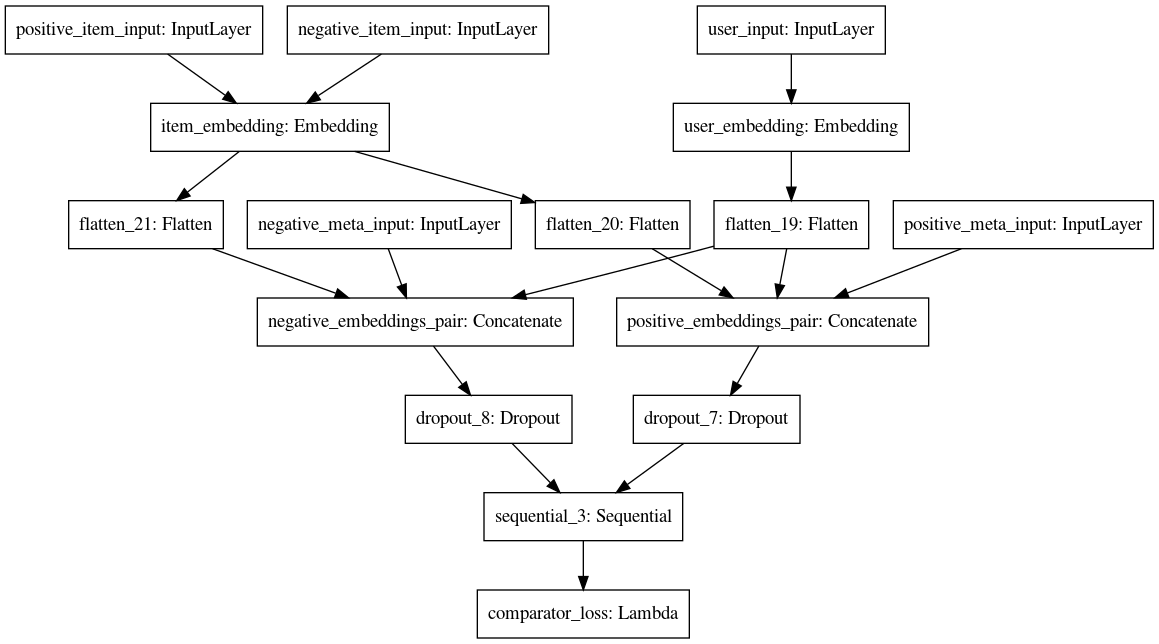

In [52]:
plot_model(deep_triplet_model, to_file='deep_triplet_model.png')
Image(filename='deep_triplet_model.png') 

The results for this model are :
- Total reward at run 0 : 118306 with conversion rate 0.256
- Total reward at run 1 : 153219 with conversion rate 0.285
- Total reward at run 2 : 121467 with conversion rate 0.237
- Mean of total reward over 3 independant runs : 130997

> <font color='blue'>
    So, even if the model is deeper, it does not improve the performance of the recommendation system at all, this may be due to the limited data available during learning.
    
    - Cumulative reward for naive model : 215357 with conversion rate 0.25
    - Cumulative reward for Dot model : 119729 with conversion rate 0.25
    - Cumulative reward for deep model : 130997 with conversion rate 0.25
    
> <font color='blue'>
    As the dataset is made up of little data, we will first favour weak classifiers such as linear classifiers rather than classifiers based on deep learning. 

## Linear Classifiers

We can transform this problem of recommending items into a problem of binary classification, i.e. predicting if for a couple (user, item) is what the reward will be strictly positive.

### 1) Logistic Regression

> <font color='blue'>
    Thus, we first build the dataset to fit the linear model.
    </font>

In [59]:
def build_dataframe(data) : 
    df = pd.DataFrame({"action":data["action_history"], "reward":data["rewards_history"], "item":data["state_history"]})
    return df

def prepare_data(df) : 
    x, y = [], []
    for action, reward, item in zip(df["action"], df["reward"], df["item"]) : 
        x.append(item[action][2:]) # We do not take care of the item_id and user_id
        y.append(reward > 0) # True if reward > 0 else False
    return x, y

params = {"user_id" : USER_ID}
data = load_data(url_reset, params)
df = build_dataframe(data)
x, y = prepare_data(df)

> <font color='blue'>
    After fiting the model: for each item in state_history, we calculate the probability that the user will buy this item, then we will choose the index of the item with the highest probability of being purchased.
    </font>

In [96]:
number_run = 3
generations = 1000
mean = 0

for k in range(1, number_run+1):
    
    # Load the data
    params = {"user_id" : USER_ID}
    data = load_data(url_reset, params)
    # Build the dataframe and prepare the data
    df = build_dataframe(data)
    x, y = prepare_data(df)
    next_state = data["next_state"]
    
    # Define the model
    logreg = LogisticRegression()
    logreg.fit(x, y)

    total_reward = 0
    purchase = 0
    
    for i in range(generations):

        predicted_item = np.argmax(logreg.predict_proba(np.array(next_state)[:,2:])[:,1])

        params['recommended_item'] = predicted_item

        r = requests.get(url = url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward
        next_state = r['state']
        
        if reward > 0 :
            purchase += 1
    
    mean += total_reward
        
    print("Total reward at run %d : %d with conversion rate : %.3f" % (k, total_reward, purchase/generations))
print("Mean of total reward over 3 independant runs : %d" % (mean/3))

Total reward at run 1 : 66697 with conversion rate : 0.291
Total reward at run 2 : 107235 with conversion rate : 0.323
Total reward at run 3 : 104483 with conversion rate : 0.327
Mean of total reward over 3 independant runs : 92805


> <font color='blue'>
    We observe that the conversion rate is better : 0.31 in average against 0.25 for Naive model. But the cumulative reward is much lower.
    </font>
    
> <font color='blue'>
    Since the reward is very closely linked to the price, it is more preferable to link the probability of the predict_proba to the price of the item: 
Thus for all probabilities of the predict_proba, we will multiply it by the price of the item: this quantity will represent a prediction of reward that the agent can earn instead of leaving only probabilities. 
    </font>

In [121]:
number_run = 3
generations = 1000
mean = 0

for k in range(1, number_run+1):
    
    # Load the data
    params = {"user_id" : USER_ID}
    data = load_data(url_reset, params)
    # Build the dataframe and prepare the data
    df = build_dataframe(data)
    x, y = prepare_data(df)
    next_state = data["next_state"]
    
    # Define the model
    logreg = LogisticRegression()
    logreg.fit(x, y)

    total_reward = 0
    purchase = 0
    
    for i in range(generations):
        
        # Multiply each probability for purchase by the price of the item
        predicted_item = np.argmax(logreg.predict_proba(np.array(next_state)[:,2:])[:,1] * np.array(next_state)[:,2])

        params['recommended_item'] = predicted_item

        r = requests.get(url = url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward
        next_state = r['state']
        
        if reward > 0 :
            purchase += 1
    
    mean += total_reward
        
    print("Total reward at run %d : %d with conversion rate : %.3f" % (k, total_reward, purchase/generations))
print("Mean of total reward over 3 independant runs : %d" % (mean/3))

Total reward at run 1 : 252430 with conversion rate : 0.284
Total reward at run 2 : 274211 with conversion rate : 0.310
Total reward at run 3 : 282086 with conversion rate : 0.326
Mean of total reward over 3 independant runs : 269576


> <font color='blue'>
    Thus, we observe that we earn more reward compared to the Naive Model, while keeping a very reasonable conversion rate (0.31 against 0.25 for the Naive Model). In a way, we outperform the naive model that does not using machine learning, so it is suffering from a high variance and bias. 
    </font>

> <font color='blue'>
    Now let's try to improve this by using online learning.
    </font>

In [120]:
number_run = 3
generations = 1000
mean = 0

for k in range(1, number_run+1):
    
    # Load the data
    params = {"user_id" : USER_ID}
    data = load_data(url_reset, params)
    # Build the dataframe and prepare the data
    df = build_dataframe(data)
    x, y = prepare_data(df)
    next_state = data["next_state"]
    
    # Define the model
    logreg = LogisticRegression()
    logreg.fit(x, y)
    
    total_reward = 0
    purchase = 0
    
    x_online = []
    y_online = []
    
    for i in range(1, generations+1):
        
        # Multiply each probability for purchase by the price of the item
        predicted_item = np.argmax(logreg.predict_proba(np.array(next_state)[:,2:])[:,1] * np.array(next_state)[:,2])
        params['recommended_item'] = predicted_item

        r = requests.get(url = url_predict, params=params).json()
        reward = r['reward']
        
        # Online learning
        x_online.append(np.array(next_state)[predicted_item, 2:])
        y_online.append(reward > 0)
        if i%30 == 0 : 
            logreg.fit(x_online, y_online)
            x_online, y_online = [], []
        
        total_reward += reward
        next_state = r['state']
        
        if reward > 0 :
            purchase += 1
    
    mean += total_reward
        
    print("Total reward at run %d : %d with conversion rate : %.3f" % (k, total_reward, purchase/generations))
print("Mean of total reward over 3 independant runs : %d" % (mean/3))

Total reward at run 1 : 256165 with conversion rate : 0.318
Total reward at run 2 : 253840 with conversion rate : 0.315
Total reward at run 3 : 251844 with conversion rate : 0.331
Mean of total reward over 3 independant runs : 253950


> <font color='blue'>
    Thus the results are almost the same with or without online learning. So we will keep online learning in order to take into account new trends.
    </font>

### 2) All linear classifier and ensemble method

Now, let's try all linear classifiers and ensemble methods : 
- logistic regressin
- SVM
- Random Forest
- Gradient Boosting
- XGBoost

In [153]:
def linear_classifier(model,online_learning, weights) :

    number_run = 3
    generations = 1000
    mean = 0

    for k in range(1, number_run+1):

        # Load the data
        params = {"user_id" : USER_ID}
        data = load_data(url_reset, params)
        # Build the dataframe and prepare the data
        df = build_dataframe(data)
        x, y = prepare_data(df)
        next_state = data["next_state"]

        # Define the model
        if model == "logreg" :
            clf = LogisticRegression()
            clf.fit(x, y)
        elif model == "svm" : 
            clf = svm.SVC()
            clf.probability = True
            clf.fit(x,y)
        elif model == "rf" :
            clf = RandomForestClassifier(n_estimators=50, min_samples_split=10)
            clf.fit(x, y)
        elif model == "GB" : 
            clf = GradientBoostingClassifier(learning_rate=0.8, n_estimators=50)
            clf.fit(x, y)
        elif model == "XGB" : 
            clf = XGBClassifier(learning_rate=0.8, n_estimators=50)
            clf.fit(np.array(x), np.array(y))

        total_reward = 0
        purchase = 0

        x_online = []
        y_online = []

        for i in range(1, generations+1):
            if weights : 
                # Multiply each probability for purchase by the price of the item
                predicted_item = np.argmax(clf.predict_proba(np.array(next_state)[:,2:])[:,1] * np.array(next_state)[:,2])
            else : 
                predicted_item = np.argmax(clf.predict_proba(np.array(next_state)[:,2:])[:,1])
            params['recommended_item'] = predicted_item

            r = requests.get(url = url_predict, params=params).json()
            reward = r['reward']

            # Online learning
            if online_learning :
                x_online.append(np.array(next_state)[predicted_item, 2:])
                y_online.append(reward > 0)
                if i%30 == 0 : 
                    clf.fit(np.array(x_online), np.array(y_online))
                    x_online, y_online = [], []

            total_reward += reward
            next_state = r['state']

            if reward > 0 :
                purchase += 1

        mean += total_reward

        print("Total reward at run %d : %d with conversion rate : %.3f" % (k, total_reward, purchase/generations))
    print("Mean of total reward over 3 independant runs : %d" % (mean/3))
    return (mean/3)

In [148]:
data = []
data_weights = []
data_online_learning = []

print("+-------------------------LogReg-------------------------+")
logreg_1 = linear_classifier(model="svm", online_learning=False, weights=False)
data.append(logreg_1)
print("+-------------------------LogReg with weights-------------------------+")
logreg_2 = linear_classifier(model="svm", online_learning=False, weights=True)
data_weights.append(logreg_2)
print("+-------------------------LogReg with online learning-------------------------+")
logreg_3 = linear_classifier(model="svm", online_learning=True, weights=True)
data_online_learning.append(logreg_3)
print('\n')
print("+-------------------------SVM-------------------------+")
svm_1 = linear_classifier(model="svm", online_learning=False, weights=False)
data.append(svm_1)
print("+-------------------------SVM with weights-------------------------+")
svm_2 = linear_classifier(model="svm", online_learning=False, weights=True) 
data_weights.append(svm_2)
print("+-------------------------SVM with online learning-------------------------+")
svm_3 = linear_classifier(model="svm", online_learning=True, weights=True)
data_online_learning.append(svm_3)
print('\n')
print("+-------------------------RF-------------------------+")
rf_1 = linear_classifier(model="rf", online_learning=False, weights=False)
data.append(rf_1)
print("+-------------------------RF with weights-------------------------+")
rf_2 = linear_classifier(model="rf", online_learning=False, weights=True)
data_weights.append(rf_2)
print("+-------------------------RF with online learning-------------------------+")
rf_3 = linear_classifier(model="rf", online_learning=True, weights=True)
data_online_learning.append(rf_3)
print('\n')
print("+-------------------------GB-------------------------+")
gb_1 = linear_classifier(model="GB", online_learning=False, weights=False)
data.append(gb_1)
print("+-------------------------GB with weights-------------------------+")
gb_2 = linear_classifier(model="GB", online_learning=False, weights=True)
data_weights.append(gb_2)
print("+-------------------------GB with online learning-------------------------+")
gb_3 = linear_classifier(model="GB", online_learning=True, weights=True)
data_online_learning.append(gb_3)
print('\n')
print("+-------------------------XGBoost-------------------------+")
xgb_1 = linear_classifier(model="XGB", online_learning=False, weights=False)
data.append(xgb_1)
print("+-------------------------XGBoost with weights-------------------------+")
xgb_2 = linear_classifier(model="XGB", online_learning=False, weights=True)
data_weights.append(xgb_2)
print("+-------------------------XGBoost with online learning-------------------------+")
xgb_3 = linear_classifier(model="XGB", online_learning=True, weights=True)
data_online_learning.append(xgb_3)

+-------------------------LogReg-------------------------+
Total reward at run 1 : 162633 with conversion rate : 0.253
Total reward at run 2 : 140144 with conversion rate : 0.336
Total reward at run 3 : 77488 with conversion rate : 0.329
Mean of total reward over 3 independant runs : 126755
+-------------------------LogReg with weights-------------------------+
Total reward at run 1 : 234390 with conversion rate : 0.253
Total reward at run 2 : 241871 with conversion rate : 0.272
Total reward at run 3 : 240670 with conversion rate : 0.298
Mean of total reward over 3 independant runs : 238977
+-------------------------LogReg with online learning-------------------------+
Total reward at run 1 : 206017 with conversion rate : 0.234
Total reward at run 2 : 264377 with conversion rate : 0.279
Total reward at run 3 : 248992 with conversion rate : 0.284
Mean of total reward over 3 independant runs : 239795


+-------------------------SVM-------------------------+
Total reward at run 1 : 150033

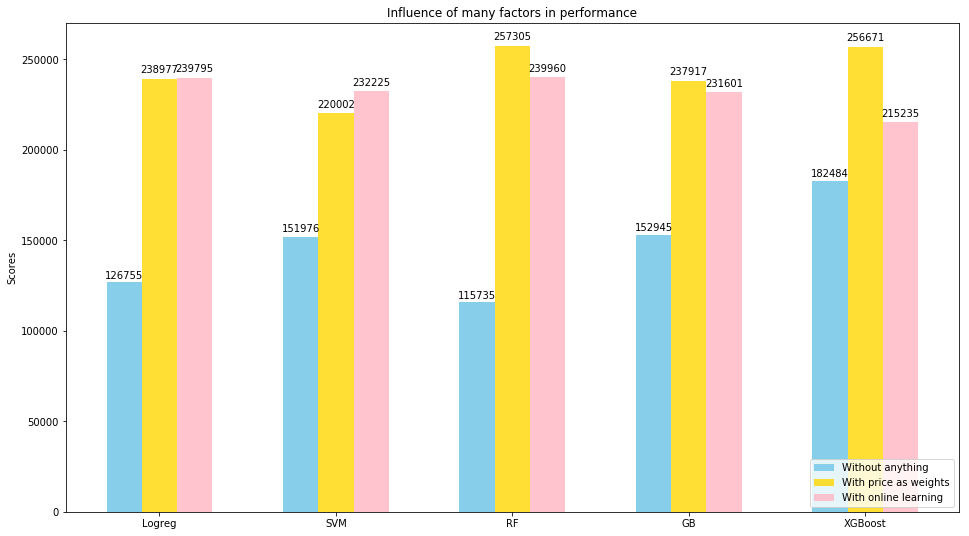

In [165]:
def autolabel(rects):
    """Attach a text label above each bar displaying its height"""
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % height,
                ha='center', va='bottom')

fig, ax = plt.subplots(figsize=(16,9))
width = 0.2
alp = 0.8
ind = np.arange(5)

label = ["Logreg", "SVM", "RF", "GB", "XGBoost"]

rects1 = ax.bar(ind, [l for l in data], 
                width = width,label='Without anything', color='skyblue')

rects2 = ax.bar(ind + width, [l for l in data_weights], 
                width, alpha=alp, label='With price as weights', color='gold')
#              
rects3 = ax.bar(ind + 2 * width, [l for l in data_online_learning], 
                width, alpha=alp, label='With online learning', color='lightpink')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Influence of many factors in performance')
ax.set_xticks(ind + 2 * width / 2)
ax.set_xticklabels(label)
#ax.set_ylim(0.4,0.9)
plt.legend(loc="lower right")

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

> <font color='blue'>
    **So our 2nd approach is the one that works the most. Moreover, online learning also gives equivalent results. It must therefore be added to our models. There are not really any classifiers who stand out from the others. The overall ensemble methods generally work better.**
    </font>